## EDA

## Inicialización

In [51]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

## Carga de datos

In [52]:
# import data
df = pd.read_parquet('../data/raw/yellow_tripdata_2022-05.parquet', engine='pyarrow')

## Analisis exploratorio

In [53]:
# Print data
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.00,4.10,1.00,N,246,151,2,17.00,3.00,0.50,0.00,0.00,0.30,20.80,2.50,0.00
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.00,2.30,1.00,N,238,74,2,11.00,3.00,0.50,0.00,0.00,0.30,14.80,2.50,0.00
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.00,4.20,1.00,N,163,260,2,15.50,3.00,0.50,0.00,0.00,0.30,19.30,2.50,0.00
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.00,0.00,1.00,N,79,182,1,41.20,0.00,0.50,0.00,0.00,0.30,42.00,0.00,0.00
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.00,1.60,1.00,N,238,75,1,7.50,3.00,0.50,2.25,0.00,0.30,13.55,2.50,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588290,2,2022-05-31 23:40:19,2022-06-01 00:01:20,NaN,0.00,NaN,None,36,181,0,20.97,0.00,0.50,1.00,0.00,0.30,22.77,NaN,NaN
3588291,2,2022-05-31 23:52:12,2022-06-01 00:06:40,NaN,2.91,NaN,None,144,256,0,11.68,0.00,0.00,2.51,0.00,0.30,16.99,NaN,NaN
3588292,2,2022-05-31 23:27:00,2022-05-31 23:48:00,NaN,3.96,NaN,None,161,145,0,14.54,0.00,0.50,0.00,0.00,0.30,17.84,NaN,NaN
3588293,2,2022-05-31 23:34:12,2022-06-01 00:00:13,NaN,6.27,NaN,None,145,17,0,24.01,0.00,0.50,5.54,0.00,0.30,30.35,NaN,NaN


In [54]:
# Show information of the data
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588295 entries, 0 to 3588294
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               3588295 non-null  int64         
 1   tpep_pickup_datetime   3588295 non-null  datetime64[us]
 2   tpep_dropoff_datetime  3588295 non-null  datetime64[us]
 3   passenger_count        3458771 non-null  float64       
 4   trip_distance          3588295 non-null  float64       
 5   RatecodeID             3458771 non-null  float64       
 6   store_and_fwd_flag     3458771 non-null  object        
 7   PULocationID           3588295 non-null  int64         
 8   DOLocationID           3588295 non-null  int64         
 9   payment_type           3588295 non-null  int64         
 10  fare_amount            3588295 non-null  float64       
 11  extra                  3588295 non-null  float64       
 12  mta_tax                35882

In [55]:
# Show descriptive statistics
# Configuración de visualización de pandas
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_rows', 100)  # Mostrar hasta 100 filas
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,"3,588,295.00",3588295,3588295,"3,458,771.00","3,588,295.00","3,458,771.00","3,588,295.00","3,588,295.00","3,588,295.00","3,588,295.00","3,588,295.00","3,588,295.00","3,588,295.00","3,588,295.00","3,588,295.00","3,588,295.00","3,458,771.00","3,458,771.00"
mean,1.71,2022-05-16 07:50:29.219312,2022-05-16 08:08:42.275203,1.39,6.86,1.37,164.57,162.55,1.18,15.17,1.02,0.49,2.82,0.58,0.30,22.08,2.28,0.10
min,1.00,2003-01-01 00:06:06,2003-01-01 00:31:38,0.00,0.00,1.00,1.00,1.00,0.00,"-1,311.50",-4.50,-0.50,-145.70,-50.75,-0.30,"-1,314.80",-2.50,-1.25
25%,1.00,2022-05-08 18:14:16.500000,2022-05-08 18:32:36,1.00,1.15,1.00,132.00,113.00,1.00,7.00,0.00,0.50,1.00,0.00,0.30,12.35,2.50,0.00
50%,2.00,2022-05-16 09:14:42,2022-05-16 09:33:15,1.00,1.96,1.00,162.00,162.00,1.00,10.50,0.50,0.50,2.16,0.00,0.30,16.30,2.50,0.00
75%,2.00,2022-05-23 18:03:17,2022-05-23 18:21:03.500000,1.00,3.73,1.00,234.00,234.00,1.00,17.00,2.50,0.50,3.46,0.00,0.30,23.76,2.50,0.00
max,6.00,2022-06-01 23:55:30,2022-06-02 00:03:51,9.00,"357,192.65",99.00,265.00,265.00,4.00,"6,966.50",8.80,3.30,665.00,813.75,0.30,"6,970.80",2.75,1.25
std,0.49,NaN,NaN,0.96,690.85,5.24,65.63,70.28,0.51,14.89,1.26,0.09,3.37,2.17,0.05,18.49,0.75,0.34


In [56]:
# Verificar si hay datos duplicados
df.duplicated().sum()

0

In [57]:
# Resumen compacto de todas las columnas en una tabla
summary = pd.DataFrame({
    'Columna': df.columns,
    'Únicos': [df[col].nunique() for col in df.columns],
    'Nulos': [df[col].isna().sum() for col in df.columns],
    'Pct_Nulos': [round(df[col].isna().sum() / len(df) * 100, 2) for col in df.columns],
    'Top_Valor': [df[col].value_counts().index[0] if len(df[col]) > 0 else None for col in df.columns],
    'Top_Freq': [df[col].value_counts().values[0] if len(df[col]) > 0 else 0 for col in df.columns]
})

display(summary)

,Columna,Únicos,Nulos,Pct_Nulos,Top_Valor,Top_Freq
0,VendorID,4,0,0.00,2,2527997
1,tpep_pickup_datetime,1754711,0,0.00,2022-05-06 19:22:00,16
2,tpep_dropoff_datetime,1752869,0,0.00,2022-05-30 00:00:00,34
3,passenger_count,10,129524,3.61,1.00,2549880
4,trip_distance,4771,0,0.00,1.00,49609
5,RatecodeID,7,129524,3.61,1.00,3256985
6,store_and_fwd_flag,2,129524,3.61,N,3404113
7,PULocationID,259,0,0.00,132,175943
8,DOLocationID,261,0,0.00,236,155644
9,payment_type,5,0,0.00,1,2720127


In [58]:
# Visualize value counts as bar plots for each column
for col in df.columns:
    print(df[col].value_counts(normalize=True))
    print()

VendorID
2   0.70
1   0.29
6   0.00
5   0.00
Name: proportion, dtype: float64

tpep_pickup_datetime
2022-05-06 19:22:00   0.00
2022-05-06 07:58:00   0.00
2022-05-06 19:01:00   0.00
2022-05-06 22:51:00   0.00
2022-05-06 19:23:00   0.00
                      ... 
2022-05-31 22:43:51   0.00
2022-05-31 22:18:25   0.00
2022-05-31 22:40:00   0.00
2022-05-31 22:12:45   0.00
2022-05-31 22:08:51   0.00
Name: proportion, Length: 1754711, dtype: float64

tpep_dropoff_datetime
2022-05-30 00:00:00   0.00
2022-06-01 00:00:00   0.00
2022-05-14 00:00:00   0.00
2022-05-07 00:00:00   0.00
2022-05-22 00:00:00   0.00
                      ... 
2022-05-31 23:14:00   0.00
2022-05-31 23:45:05   0.00
2022-06-01 00:32:23   0.00
2022-06-01 00:14:00   0.00
2022-05-31 23:30:50   0.00
Name: proportion, Length: 1752869, dtype: float64

passenger_count
1.00   0.74
2.00   0.16
3.00   0.04
0.00   0.02
5.00   0.02
4.00   0.02
6.00   0.01
7.00   0.00
8.00   0.00
9.00   0.00
Name: proportion, dtype: float64

trip_distanc

In [59]:
# Resumen de nulos por columna
nulos_por_columna = pd.DataFrame({
    'Columna': df.columns,
    'Total_Nulos': [df[col].isna().sum() for col in df.columns],
    'Pct_Nulos': [round(df[col].isna().sum() / len(df) * 100, 2) for col in df.columns]
}).sort_values('Total_Nulos', ascending=False)

# Mostrar solo columnas con nulos
nulos_por_columna_filtrado = nulos_por_columna[nulos_por_columna['Total_Nulos'] > 0]

print("\nColumnas con valores nulos:")
display(nulos_por_columna_filtrado)

# Insight rápido
print(f"\n📊 Resumen:")
print(f"   • Columnas con nulos: {len(nulos_por_columna_filtrado)}")
print(f"   • Columnas sin nulos: {len(df.columns) - len(nulos_por_columna_filtrado)}")


Columnas con valores nulos:


,Columna,Total_Nulos,Pct_Nulos
6,store_and_fwd_flag,129524,3.61
5,RatecodeID,129524,3.61
3,passenger_count,129524,3.61
18,airport_fee,129524,3.61
17,congestion_surcharge,129524,3.61



📊 Resumen:
   • Columnas con nulos: 5
   • Columnas sin nulos: 14


### Conclusiones y siguientes pasos

Los datos tienen los tipos de datos correctos. Por otro lado, se han encontrado que las siguientes columnas tienen datos nulos:
- passenger_count
- trip_distance
- RatecodeID
- store_and_fwd_flag
- payment_type
- congestion_surcharge

Estos representan el 3.61% de los datos totales y tienen la misma cantidad de nulos en cada una de estas columnas. Analizaremos los valores nulos de las columnas con nulos para ver como tratarlos correctamente.

Por otro lado, las columnas trip_distance, fare_amount, total_amount y tip_amount tienen outiliers los cuales también serán estudiados.

## Procesamiento de datos

Antes de hacer el análisis de los datos, se procederá a cambiar los nombres de las columnas para que sigan el snake_case.

In [60]:
# Crear función para cambiar nombres de columnas
def to_snake_case(name):
    name = name.replace(' ', '_')
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Rename the columns using the to_snake_case function
df.columns = [to_snake_case(col) for col in df.columns]
df.head()

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.00,4.10,1.00,N,246,151,2,17.00,3.00,0.50,0.00,0.00,0.30,20.80,2.50,0.00
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.00,2.30,1.00,N,238,74,2,11.00,3.00,0.50,0.00,0.00,0.30,14.80,2.50,0.00
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.00,4.20,1.00,N,163,260,2,15.50,3.00,0.50,0.00,0.00,0.30,19.30,2.50,0.00
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.00,0.00,1.00,N,79,182,1,41.20,0.00,0.50,0.00,0.00,0.30,42.00,0.00,0.00
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.00,1.60,1.00,N,238,75,1,7.50,3.00,0.50,2.25,0.00,0.30,13.55,2.50,0.00


### Tratamiento de valores ausentes

Lo primero que derteminaremos es si estos valores ausentes son independientes o no.

In [61]:
# Columnas con nulos
cols_con_nulos = df.columns[df.isna().any()].tolist()

# Verificación final: ¿Cuando una es nula, TODAS son nulas?
print("\n Verificación: ¿Cuando falta una, faltan todas?")
print("-" * 70)

# Tomar la primera columna como referencia
col_referencia = cols_con_nulos[0]
registros_nulos_ref = df[col_referencia].isna()

# Verificar si coincide con las demás
todas_coinciden = True
for col in cols_con_nulos[1:]:
    coinciden = (df[col].isna() == registros_nulos_ref).all()
    simbolo = "✅" if coinciden else "❌"
    print(f"{simbolo} {col_referencia} vs {col}: {'Coinciden 100%' if coinciden else 'NO coinciden'}")
    if not coinciden:
        todas_coinciden = False



 Verificación: ¿Cuando falta una, faltan todas?
----------------------------------------------------------------------
✅ passenger_count vs ratecode_id: Coinciden 100%
✅ passenger_count vs store_and_fwd_flag: Coinciden 100%
✅ passenger_count vs congestion_surcharge: Coinciden 100%
✅ passenger_count vs airport_fee: Coinciden 100%


Al parecer, los nulos son independientes. Es decir los nulos coinciden en las mismas filas. Ahora procederemos a buscar la causa común de los nulos, para ello compararemos los valores de las columnas categóricas de las filas con nulos con las mismas columnas de las filas sin nulos.

In [62]:
# Crear máscara de registros con nulos (usar cualquier columna, son las mismas)
tiene_nulos = df['passenger_count'].isna()


# ===================================================================
# Estrategia: Revisar campos categóricos para encontrar el patrón
# ===================================================================

# Campos categóricos clave a investigar
campos_investigar = ['vendor_id', 'payment_type', 'ratecode_id', 'store_and_fwd_flag']

for campo in campos_investigar:
    print(f"\n🔍 Campo: {campo}")
    print("-" * 70)
    
    # Ver valores únicos en registros CON nulos
    valores_en_nulos = df[tiene_nulos][campo].value_counts(dropna=False)
    
    # Comparar
    print(f"Valores en registros CON nulos:")
    print(valores_en_nulos)
    
    # TEST CLAVE: ¿Algún valor tiene 100% de nulos?
    print(f"\n% de nulos por cada valor de {campo}:")
    for valor in df[campo].dropna().unique():
        registros_con_este_valor = df[campo] == valor
        nulos_en_este_valor = (df[registros_con_este_valor]['passenger_count'].isna()).sum()
        total_este_valor = registros_con_este_valor.sum()
        pct = (nulos_en_este_valor / total_este_valor * 100) if total_este_valor > 0 else 0
        
        if pct == 100.0:
            print(f"   {valor}: {pct:.1f}% ⚠️ ¡TODOS los registros tienen nulos!")
        elif pct > 50:
            print(f"   {valor}: {pct:.1f}% ⚠️")
        elif pct > 0:
            print(f"   {valor}: {pct:.1f}%")
        else:
            print(f"   {valor}: {pct:.1f}%")



🔍 Campo: vendor_id
----------------------------------------------------------------------
Valores en registros CON nulos:
vendor_id
2    109830
1     13526
6      6154
5        14
Name: count, dtype: int64

% de nulos por cada valor de vendor_id:
   1: 1.3%


   2: 4.3%
   6: 100.0% ⚠️ ¡TODOS los registros tienen nulos!
   5: 100.0% ⚠️ ¡TODOS los registros tienen nulos!

🔍 Campo: payment_type
----------------------------------------------------------------------
Valores en registros CON nulos:
payment_type
0    129524
Name: count, dtype: int64

% de nulos por cada valor de payment_type:
   2: 0.0%
   1: 0.0%
   4: 0.0%
   3: 0.0%
   0: 100.0% ⚠️ ¡TODOS los registros tienen nulos!

🔍 Campo: ratecode_id
----------------------------------------------------------------------
Valores en registros CON nulos:
ratecode_id
NaN    129524
Name: count, dtype: int64

% de nulos por cada valor de ratecode_id:
   1.0: 0.0%
   2.0: 0.0%
   4.0: 0.0%
   5.0: 0.0%
   99.0: 0.0%
   3.0: 0.0%
   6.0: 0.0%

🔍 Campo: store_and_fwd_flag
----------------------------------------------------------------------
Valores en registros CON nulos:
store_and_fwd_flag
None    129524
Name: count, dtype: int64

% de nulos por cada valor de store_and_fwd_flag:
   N: 0.0%
   Y: 

Hemos encontrado que todos los registros nulos son del tipo de pago Flex Fare trip (0), este tipo de pago es relacionado a taxis por aplicativo. Por otro lado, tenemos dos vendors que tienen un 100% de nulos, estos vendors son el 5 (no registrado) y el 6-Myle Technologies Inc (relacionado con apps de taxis).

In [63]:
# Filtrar registros con payment_type = 0
df_flex = df[df['payment_type'] == 0]

df_flex.describe()

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,"129,524.00",129524,129524,0.00,"129,524.00",0.00,"129,524.00","129,524.00","129,524.00","129,524.00","129,524.00","129,524.00","129,524.00","129,524.00","129,524.00","129,524.00",0.00,0.00
mean,2.09,2022-05-15 08:14:21.939200,2022-05-15 08:36:09.739477,NaN,93.67,NaN,161.13,152.63,0.00,22.52,0.04,0.49,4.16,0.80,0.30,30.52,NaN,NaN
min,1.00,2022-05-01 00:00:00,2022-05-01 00:05:19,NaN,0.00,NaN,1.00,1.00,0.00,-105.19,0.00,0.00,0.00,0.00,0.00,-87.70,NaN,NaN
25%,2.00,2022-05-07 13:25:54.250000,2022-05-07 13:51:05.500000,NaN,2.10,NaN,97.00,100.00,0.00,12.27,0.00,0.50,2.00,0.00,0.30,18.05,NaN,NaN
50%,2.00,2022-05-14 18:39:14.500000,2022-05-14 19:05:00,NaN,3.62,NaN,161.00,144.00,0.00,17.86,0.00,0.50,3.38,0.00,0.30,24.66,NaN,NaN
75%,2.00,2022-05-22 02:56:37.500000,2022-05-22 03:14:00,NaN,6.40,NaN,236.00,230.00,0.00,27.10,0.00,0.50,5.30,0.00,0.30,35.74,NaN,NaN
max,6.00,2022-05-31 23:59:53,2022-06-01 00:32:23,NaN,"357,192.65",NaN,265.00,265.00,0.00,181.95,5.75,0.50,52.26,45.00,0.30,218.31,NaN,NaN
std,0.93,NaN,NaN,NaN,"3,634.02",NaN,76.40,72.21,0.00,15.18,0.21,0.05,3.55,2.55,0.01,18.65,NaN,NaN


Teniendo en cuenta que los registros con el tipo de pago Flex Fare trip (0) son válidos y es posible que la cuasa de los valores nulos correspondientes a estos casos sean poeque estos datos no se resgistran ya qeu son viajes provenientes de apps de taxis, no se eliminarán. Sin embargo, los registros del vendor 5 si serán eliminados ya que no corresponden a ningún vendor registrado.

In [64]:
# Filtrar registros del vendor 5
df = df[df['vendor_id'] != 5]

In [65]:
# Verificar resultados
df['vendor_id'].value_counts()

vendor_id
2    2527997
1    1054130
6       6154
Name: count, dtype: int64

### Tratamiento de outliers

In [66]:
df.describe()

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,"3,588,281.00",3588281,3588281,"3,458,771.00","3,588,281.00","3,458,771.00","3,588,281.00","3,588,281.00","3,588,281.00","3,588,281.00","3,588,281.00","3,588,281.00","3,588,281.00","3,588,281.00","3,588,281.00","3,588,281.00","3,458,771.00","3,458,771.00"
mean,1.71,2022-05-16 07:50:30.321662,2022-05-16 08:08:43.370610,1.39,6.86,1.37,164.57,162.55,1.18,15.17,1.02,0.49,2.82,0.58,0.30,22.08,2.28,0.10
min,1.00,2003-01-01 00:06:06,2003-01-01 00:31:38,0.00,0.00,1.00,1.00,1.00,0.00,"-1,311.50",-4.50,-0.50,-145.70,-50.75,-0.30,"-1,314.80",-2.50,-1.25
25%,1.00,2022-05-08 18:14:17,2022-05-08 18:32:37,1.00,1.15,1.00,132.00,113.00,1.00,7.00,0.00,0.50,1.00,0.00,0.30,12.35,2.50,0.00
50%,2.00,2022-05-16 09:14:43,2022-05-16 09:33:17,1.00,1.96,1.00,162.00,162.00,1.00,10.50,0.50,0.50,2.16,0.00,0.30,16.30,2.50,0.00
75%,2.00,2022-05-23 18:03:17,2022-05-23 18:21:04,1.00,3.73,1.00,234.00,234.00,1.00,17.00,2.50,0.50,3.46,0.00,0.30,23.76,2.50,0.00
max,6.00,2022-06-01 23:55:30,2022-06-02 00:03:51,9.00,"357,192.65",99.00,265.00,265.00,4.00,"6,966.50",8.80,3.30,665.00,813.75,0.30,"6,970.80",2.75,1.25
std,0.49,NaN,NaN,0.96,690.85,5.24,65.63,70.28,0.51,14.89,1.26,0.09,3.37,2.17,0.05,18.49,0.75,0.34


##### Trip Distance

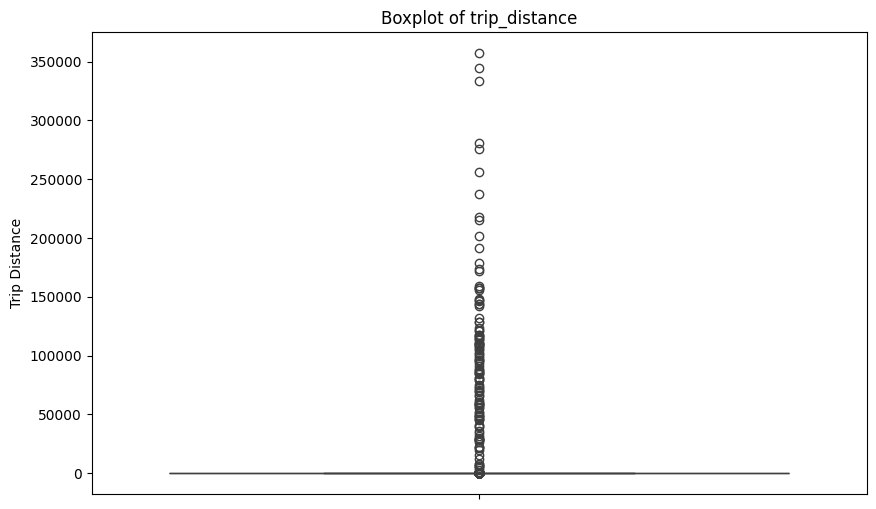

In [67]:
# Boxplot de trip_distance

plt.figure(figsize=(10, 6))
sns.boxplot(y=df['trip_distance'])
plt.title('Boxplot of trip_distance')
plt.ylabel('Trip Distance')
plt.show()

Como podemos observar, el boxplot muestra que hay varios viajes con distancias atípicas. Esto puede ser porque hay viajes que no son dentro de New York, por lo que se procederá a eliminar estos viajes.

Para ello analicemos los valores de las columnas PULocationID y DOLocationID.

In [68]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3588281 entries, 0 to 3588294
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   vendor_id              3588281 non-null  int64         
 1   tpep_pickup_datetime   3588281 non-null  datetime64[us]
 2   tpep_dropoff_datetime  3588281 non-null  datetime64[us]
 3   passenger_count        3458771 non-null  float64       
 4   trip_distance          3588281 non-null  float64       
 5   ratecode_id            3458771 non-null  float64       
 6   store_and_fwd_flag     3458771 non-null  object        
 7   pu_location_id         3588281 non-null  int64         
 8   do_location_id         3588281 non-null  int64         
 9   payment_type           3588281 non-null  int64         
 10  fare_amount            3588281 non-null  float64       
 11  extra                  3588281 non-null  float64       
 12  mta_tax                3588281 no

In [69]:
print(df['pu_location_id'].unique())
print(df['do_location_id'].unique())
# Verificar valores únicos de PULocationID y DOLocationID

[246 238 163  79 249 164  68  48 170 151 236 142 230 234  90 264 237 114
  50 186 138 161 158 229 132 211 209 162 125 262 148 137 263 239 141   4
 100 233  43  87 107 113 181  70 244 140  66 143 231  24 112  74  97  88
 144  45 232 217  42 152  41  80 261   7  82  47  75 256 189 166 226 130
 145  25 146 179  13 243 223  37  10  36  52  40 255  49  95 116 265  65
  19 154 235 224 190 259 241 168  61 254 115 193 257 219  33 174  46 184
 213  17 247 198  83  85  56 188 129  55 185 260 159 216  69 225 167 160
 106 212  14 242 202  89 157  38  76 197   1 180 134 215  32  51  35 195
 194 133 153  91 105  78  96 127 182  81 169 171 203 228 126  86 135 196
 220   3 155  67 200  31  73  64  21 183  92 121 117 149 248  18  53  22
 205 177  12  44 136  26 118  62 119 250 147 165  93  60 150 124  28  94
 191 208 192 123 221  34 258  71 122 207 128 131  39 173  23  11 210 139
  29 108 101 218 175  20  15  54 253 178  16 102  72 156   8 120 206   9
  77 222  98  63 172  57 227 201 252 111 240   5 21

Según la documentación, los valores de PULocationID y DOLocationID que son 1, 264 y 265 son ubicaciones fuera de New York.

In [70]:
# Verificar valores únicos de PULocationID y DOLocationID
# Ver cuántos viajes serán eliminados
ubicaciones_excluir = [1, 264, 265]

viajes_a_eliminar = (
    df['pu_location_id'].isin(ubicaciones_excluir) | 
    df['do_location_id'].isin(ubicaciones_excluir)
)

print(f"Total original: {len(df):,}")
print(f"A eliminar: {viajes_a_eliminar.sum():,} ({viajes_a_eliminar.sum()/len(df)*100:.2f}%)")
print(f"Quedarán: {len(df) - viajes_a_eliminar.sum():,}")

Total original: 3,588,281
A eliminar: 77,364 (2.16%)
Quedarán: 3,510,917


Estos solo equivalesn a 2.16% de los datos, por lo que se procederá a filtrar estos viajes.

In [74]:
# Filtrar los locaclizaciones fuera de New York
df = df[
    ~df['pu_location_id'].isin([1, 264, 265]) & 
    ~df['do_location_id'].isin([1, 264, 265])
]


In [79]:
print(df['pu_location_id'].isin([1, 264, 265]).sum())
print(df['do_location_id'].isin([1, 264, 265]).sum())

0
0


In [80]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3510917 entries, 0 to 3588294
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   vendor_id              3510917 non-null  int64         
 1   tpep_pickup_datetime   3510917 non-null  datetime64[us]
 2   tpep_dropoff_datetime  3510917 non-null  datetime64[us]
 3   passenger_count        3389881 non-null  float64       
 4   trip_distance          3510917 non-null  float64       
 5   ratecode_id            3389881 non-null  float64       
 6   store_and_fwd_flag     3389881 non-null  object        
 7   pu_location_id         3510917 non-null  int64         
 8   do_location_id         3510917 non-null  int64         
 9   payment_type           3510917 non-null  int64         
 10  fare_amount            3510917 non-null  float64       
 11  extra                  3510917 non-null  float64       
 12  mta_tax                3510917 no

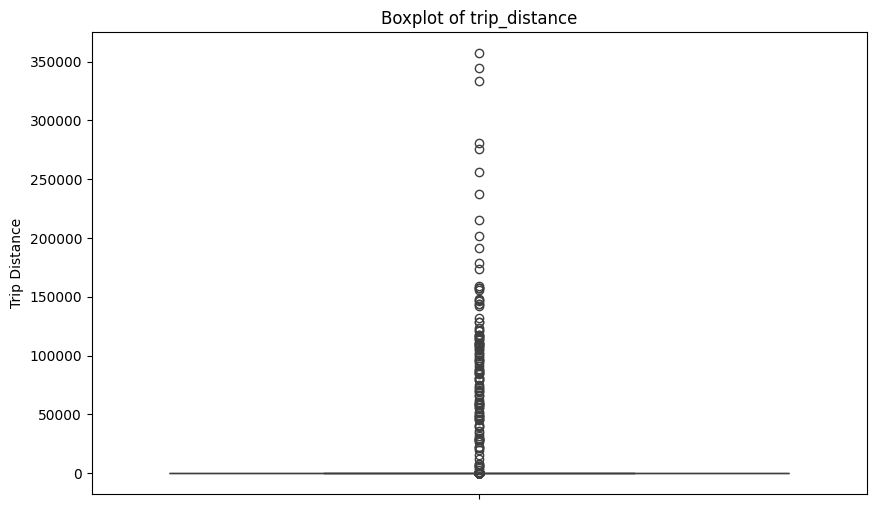

In [81]:
# Boxplot de trip_distance

plt.figure(figsize=(10, 6))
sns.boxplot(y=df['trip_distance'])
plt.title('Boxplot of trip_distance')
plt.ylabel('Trip Distance')
plt.show()

In [82]:
df['trip_distance'].describe()
# Comparar Flex Fare vs otros payment types

count   3,510,917.00
mean            6.69
std           682.55
min             0.00
25%             1.14
50%             1.93
75%             3.63
max       357,192.65
Name: trip_distance, dtype: float64

In [114]:
# Value counts con distancias redondeadas (sin decimales)
distancias_redondeadas = df['trip_distance'].round(0).astype(int)
value_counts = distancias_redondeadas.value_counts().sort_index(ascending=False)

print(f"{'Distancia (mi)':>15}  {'Cantidad':>10}")
print("="*30)

for distancia, cantidad in value_counts.items():
    print(f"{distancia:>15}  {cantidad:>10,}")

 Distancia (mi)    Cantidad
         357193           1
         344408           1
         333633           1
         281180           1
         275692           1
         255754           1
         237130           1
         215539           1
         201873           1
         191630           1
         178999           1
         173700           1
         159097           1
         157703           1
         157164           1
         157062           1
         155617           1
         148449           1
         147207           1
         146568           1
         143979           1
         143619           1
         141756           1
         131884           1
         128743           1
         128600           1
         123340           1
         121507           1
         121127           1
         117154           1
         117114           1
         116857           1
         116069           1
         114583           1
         114305     

In [116]:
# ===================================================================
# COMPARAR TODOS LOS MÉTODOS
# ===================================================================

print("\n" + "="*70)
print("COMPARACIÓN DE TODOS LOS MÉTODOS")
print("="*70)

from scipy import stats

# Calcular todos los umbrales
Q1 = df['trip_distance'].quantile(0.25)
Q3 = df['trip_distance'].quantile(0.75)
IQR = Q3 - Q1

metodos = {
    'IQR (Q3 + 1.5*IQR)': Q3 + 1.5 * IQR,
    'Z-Score (μ + 3σ)': df['trip_distance'].mean() + 3 * df['trip_distance'].std(),
    'MAD (Med + 3.5*MAD)': df['trip_distance'].median() + (3.5 * stats.median_abs_deviation(df['trip_distance']) / 0.6745),
    'Percentil 99.9%': df['trip_distance'].quantile(0.999),
    'Percentil 99.5%': df['trip_distance'].quantile(0.995),
    'Percentil 99.0%': df['trip_distance'].quantile(0.99),
    'Visual (50 mi)': 50,
    'Contexto NYC (100 mi)': 100
}

print(f"\n{'Método':<25} {'Umbral':>12} {'Elimina':>12} {'%':>8}")
print("-"*70)

resultados = []
for nombre, umbral in metodos.items():
    n_elimina = (df['trip_distance'] > umbral).sum()
    pct = (n_elimina / len(df)) * 100
    resultados.append((nombre, umbral, n_elimina, pct))
    print(f"{nombre:<25} {umbral:>10.2f} mi {n_elimina:>10,}   {pct:>6.3f}%")

# Encontrar el mejor
print("\n" + "="*70)
print("ANÁLISIS CRÍTICO")
print("="*70)

print("""
🔴 IQR: Probablemente DEMASIADO RESTRICTIVO
   - Diseñado para distribuciones simétricas
   - trip_distance es muy asimétrica (sesgada a la derecha)
   - Eliminaría viajes largos pero legítimos

🟡 Z-Score: POCO ROBUSTO para estos datos
   - Asume distribución normal (NO es tu caso)
   - Afectado por outliers extremos
   - No recomendado aquí

🟢 MAD: ROBUSTO y estadísticamente sólido
   - No asume distribución normal
   - Robusto a outliers extremos
   - BUENA OPCIÓN estadística

🟢 Percentil 99.9%: MUY RECOMENDADO
   - Estadísticamente válido
   - Fácil de interpretar
   - No hace suposiciones sobre distribución
   - Conservador (solo elimina 0.1%)

🟢 Visual (50 mi): JUSTIFICABLE
   - Basado en inspección de datos
   - Razonable para dominio (NYC)
   - Transparente y reproducible
""")


COMPARACIÓN DE TODOS LOS MÉTODOS



Método                          Umbral      Elimina        %
----------------------------------------------------------------------
IQR (Q3 + 1.5*IQR)              7.37 mi    430,562   12.264%
Z-Score (μ + 3σ)             2054.34 mi        117    0.003%
MAD (Med + 3.5*MAD)             7.02 mi    449,463   12.802%
Percentil 99.9%                25.90 mi      3,497    0.100%
Percentil 99.5%                21.16 mi     17,519    0.499%
Percentil 99.0%                19.86 mi     35,074    0.999%
Visual (50 mi)                 50.00 mi        152    0.004%
Contexto NYC (100 mi)         100.00 mi        119    0.003%

ANÁLISIS CRÍTICO

🔴 IQR: Probablemente DEMASIADO RESTRICTIVO
   - Diseñado para distribuciones simétricas
   - trip_distance es muy asimétrica (sesgada a la derecha)
   - Eliminaría viajes largos pero legítimos

🟡 Z-Score: POCO ROBUSTO para estos datos
   - Asume distribución normal (NO es tu caso)
   - Afectado por outliers extremos
   - No recomendado aquí

🟢 MAD: ROBUSTO y

In [102]:
# Ver distancias únicas ordenadas de mayor a menor
distancias_ordenadas = df['trip_distance'].sort_values(ascending=False).drop_duplicates().reset_index(drop=True)

# Mostrar las primeras 100 para ver dónde está el salto
print("Top 100 distancias únicas (de mayor a menor):")
print("="*60)
print(f"{'#':<5} {'Distancia':<15} {'Frecuencia':<12}")
print("-"*60)

for i in range(min(200, len(distancias_ordenadas))):
    dist = distancias_ordenadas[i]
    freq = (df['trip_distance'] == dist).sum()
    print(f"{i+1:<5} {dist:<15.2f} {freq:<12}")

Top 100 distancias únicas (de mayor a menor):
#     Distancia       Frecuencia  
------------------------------------------------------------
1     357192.65       1           
2     344408.48       1           
3     333632.96       1           
4     281179.94       1           
5     275692.34       1           
6     255753.73       1           
7     237129.53       1           
8     215538.85       1           
9     201873.37       1           
10    191630.40       1           
11    178999.27       1           
12    173699.66       1           
13    159097.41       1           
14    157703.25       1           
15    157163.56       1           
16    157061.56       1           
17    155616.52       1           
18    148448.91       1           
19    147207.11       1           
20    146568.26       1           
21    143979.33       1           
22    143619.15       1           
23    141756.24       1           
24    131884.34       1           
25    128742.58   

In [105]:
# ===================================================================
# VERIFICACIÓN 1: COMPARAR ELIMINADOS VS CONSERVADOS
# ===================================================================

print("\n" + "="*70)
print("VERIFICACIÓN 1: ¿QUÉ SE ELIMINA VS QUÉ SE CONSERVA?")
print("="*70)

umbral = df['trip_distance'].quantile(0.999)

print(f"\nUmbral (percentil 99.9%): {umbral:.2f} millas\n")

# Lo que se ELIMINARÍA
print("🗑️  VIAJES A ELIMINAR (top 20):")
print("-"*70)
eliminados = df[df['trip_distance'] > umbral]['trip_distance'].sort_values(ascending=False)
for i, dist in enumerate(eliminados.head(20), 1):
    print(f"{i:2}. {dist:>12.2f} millas")

# Lo que se CONSERVARÍA (los más altos que quedan)
print(f"\n✅ VIAJES MÁS LARGOS QUE SE CONSERVARÍAN (top 20):")
print("-"*70)
conservados = df[df['trip_distance'] <= umbral]['trip_distance'].sort_values(ascending=False)
for i, dist in enumerate(conservados.head(20), 1):
    print(f"{i:2}. {dist:>12.2f} millas")

print("""
🎯 PREGUNTA CLAVE: 
¿Los valores eliminados parecen errores?
¿Los valores conservados parecen razonables?

Si SÍ → El percentil 99.9% es apropiado
Si NO → Ajustar el percentil
""")


VERIFICACIÓN 1: ¿QUÉ SE ELIMINA VS QUÉ SE CONSERVA?

Umbral (percentil 99.9%): 25.90 millas

🗑️  VIAJES A ELIMINAR (top 20):
----------------------------------------------------------------------
 1.    357192.65 millas
 2.    344408.48 millas
 3.    333632.96 millas
 4.    281179.94 millas
 5.    275692.34 millas
 6.    255753.73 millas
 7.    237129.53 millas
 8.    215538.85 millas
 9.    201873.37 millas
10.    191630.40 millas
11.    178999.27 millas
12.    173699.66 millas
13.    159097.41 millas
14.    157703.25 millas
15.    157163.56 millas
16.    157061.56 millas
17.    155616.52 millas
18.    148448.91 millas
19.    147207.11 millas
20.    146568.26 millas

✅ VIAJES MÁS LARGOS QUE SE CONSERVARÍAN (top 20):
----------------------------------------------------------------------
 1.        25.90 millas
 2.        25.90 millas
 3.        25.90 millas
 4.        25.90 millas
 5.        25.90 millas
 6.        25.90 millas
 7.        25.90 millas
 8.        25.90 millas
 9.      

In [104]:
# ===================================================================
# VERIFICACIÓN 2: ¿HAY UN SALTO CLARO?
# ===================================================================

print("\n" + "="*70)
print("VERIFICACIÓN 2: ANALIZAR EL SALTO")
print("="*70)

# Ver valores alrededor del percentil 99.9%
percentiles_finos = [99.8, 99.85, 99.9, 99.92, 99.94, 99.96, 99.98, 99.99]

print("\nPercentil    Valor        Diferencia con anterior")
print("-"*60)

anterior = None
for p in percentiles_finos:
    valor = df['trip_distance'].quantile(p/100)
    
    if anterior is not None:
        diff = valor - anterior
        print(f"{p:>6.2f}%    {valor:>8.2f} mi    +{diff:>8.2f} mi")
    else:
        print(f"{p:>6.2f}%    {valor:>8.2f} mi")
    
    anterior = valor

print("""
🔍 Buscar:
  • Diferencias pequeñas (5-10 millas) → valores normales
  • Salto GRANDE (100+ millas) → empieza la zona de outliers

Si ves un salto grande cerca del 99.9%, confirma que es buen umbral.
""")


VERIFICACIÓN 2: ANALIZAR EL SALTO

Percentil    Valor        Diferencia con anterior
------------------------------------------------------------
 99.80%       22.90 mi
 99.85%       24.00 mi    +    1.10 mi
 99.90%       25.90 mi    +    1.90 mi
 99.92%       26.58 mi    +    0.68 mi
 99.94%       27.43 mi    +    0.85 mi
 99.96%       28.33 mi    +    0.90 mi
 99.98%       30.13 mi    +    1.80 mi
 99.99%       35.20 mi    +    5.07 mi

🔍 Buscar:
  • Diferencias pequeñas (5-10 millas) → valores normales
  • Salto GRANDE (100+ millas) → empieza la zona de outliers

Si ves un salto grande cerca del 99.9%, confirma que es buen umbral.



In [99]:
# Ver dónde está el salto en los percentiles altos
import numpy as np

percentiles = [95, 96, 97, 98, 99, 99.5, 99.9, 99.95, 99.99, 100]
print("Percentil    Distancia")
print("-" * 30)
for p in percentiles:
    valor = df['trip_distance'].quantile(p/100)
    print(f"{p:>6}%  →  {valor:>10,.2f} millas")

Percentil    Distancia
------------------------------
    95%  →       14.88 millas
    96%  →       16.89 millas
    97%  →       17.72 millas
    98%  →       18.50 millas
    99%  →       19.86 millas
  99.5%  →       21.16 millas
  99.9%  →       25.90 millas
 99.95%  →       27.90 millas
 99.99%  →       35.20 millas
   100%  →  357,192.65 millas


In [ ]:
# Comparar Flex Fare vs otros payment types
print("="*70)
print("COMPARACIÓN: FLEX FARE vs OTROS TIPOS DE PAGO")
print("="*70)

flex_fare = df[df['payment_type'] == 0]
otros_pagos = df[df['payment_type'] != 0]

comparacion = pd.DataFrame({
    'Métrica': [
        'Total registros',
        'Distancia promedio (millas)',
        'Tarifa promedio ($)',
        'Propina promedio ($)',
        '% con propina > 0',
        'Total_amount promedio ($)',
        'VendorID más común'
    ],
    'Flex Fare (0)': [
        f"{len(flex_fare):,}",
        f"{flex_fare['trip_distance'].median():.2f}",  # Usar mediana por outliers
        f"{flex_fare['fare_amount'].mean():.2f}",
        f"{flex_fare['tip_amount'].mean():.2f}",
        f"{(flex_fare['tip_amount'] > 0).mean() * 100:.1f}%",
        f"{flex_fare['total_amount'].mean():.2f}",
        f"{flex_fare['VendorID'].mode()[0]}"
    ],
    'Otros Tipos': [
        f"{len(otros_pagos):,}",
        f"{otros_pagos['trip_distance'].median():.2f}",
        f"{otros_pagos['fare_amount'].mean():.2f}",
        f"{otros_pagos['tip_amount'].mean():.2f}",
        f"{(otros_pagos['tip_amount'] > 0).mean() * 100:.1f}%",
        f"{otros_pagos['total_amount'].mean():.2f}",
        f"{otros_pagos['VendorID'].mode()[0]}"
    ]
})

display(comparacion)

# Investigar outliers de distancia
print("\n" + "="*70)
print("OUTLIERS DE DISTANCIA EN FLEX FARE")
print("="*70)
print(flex_fare.nlargest(10, 'trip_distance')[
    ['VendorID', 'trip_distance', 'fare_amount', 'total_amount', 
     'tpep_pickup_datetime', 'PULocationID', 'DOLocationID']
])

### Tratamiento de outliers

Ahora procederemos a estudiar los outliers de las columnas trip_distance, fare_amount, total_amount y tip_amount.

In [ ]:
# Establecer columnas numéricas y categóricas
numeric_cols = ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount']
categorical_cols = ['vendor_id', 'payment_type', 'ratecode_id', 'store_and_fwd_flag']

# Imprimir las columnas numéricas y categóricas
print("Columnas numéricas:", numeric_cols)
print("Columnas categóricas:", categorical_cols)

In [ ]:
# Graficar histogramas por columna
sns.set(style="ticks")

num_vars = len(numeric_cols)
num_rows = num_vars // 2
num_rows += num_vars % 2 

# Crear sub gráficos
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows*5)) 

# Aplanar el arreglo de ejes para que podamos iterar sobre él fácilmente
axes = axes.flatten()

# Iterar por cada columna numérica y crear histograma
for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=16, color='slategray', edgecolor="black", linewidth=0.8)
    
    # Dibujar líneas para media y mediana
    mean_val = df[col].mean()
    median_val = df[col].median()
    mean_line = axes[i].axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
    median_line = axes[i].axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)

    print(f'{col}:')
    print(f'Median: {median_val}')
    print(f'Mean: {median_val}')
    print()
    
    # Anadir leyenda
    axes[i].legend([mean_line, median_line], ['mean', 'median'])
    axes[i].set_title(f'Histogram of {col}', fontsize=16)
    
# Remover sub gráficos no usados
if len(numeric_cols) % 2:
    for j in range(i+1, num_rows*2):
        fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

In [ ]:
# Graficar boxplots por columna
sns.set(style="ticks")

num_vars = len(numeric_cols)
num_rows = num_vars // 2
num_rows += num_vars % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows*5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], color='slategray', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=20, weight='bold')
    axes[i].set_xlabel(col, fontsize=16)
    
    mean_val = df[col].mean()
    median_val = df[col].median()
    q1_val = df[col].quantile(0.25)
    q3_val = df[col].quantile(0.75)
    
    mean_line = axes[i].axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
    median_line = axes[i].axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)
    
    # Annotate the lines
    axes[i].annotate(f'Q1: {q1_val:.2f}', xy=(q1_val, 0), xytext=(q1_val, -0.6),
                     textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black'), fontsize=12)
    axes[i].annotate(f'Q3: {q3_val:.2f}', xy=(q3_val, 0), xytext=(q3_val, -0.8),
                     textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black'), fontsize=12)
    
    print(f'{col}:')
    print(f'Median: {median_val}')
    print(f'Mean: {mean_val}')
    print()
    
    axes[i].legend([mean_line, median_line], ['Mean', 'Median'])
    axes[i].set_title(f'Boxplot of {col}', fontsize=16)

plt.tight_layout()
plt.show()

## Análisis de datos

In [ ]:
# Establecer columnas numéricas y categóricas
numeric_cols = ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount']
categorical_cols = ['vendor_id', 'payment_type', 'ratecode_id', 'store_and_fwd_flag']

# Imprimir las columnas numéricas y categóricas
print("Columnas numéricas:", numeric_cols)
print("Columnas categóricas:", categorical_cols)


In [ ]:
# Graficar histogramas por columna
sns.set(style="ticks")

num_vars = len(numeric_cols)
num_rows = num_vars // 2
num_rows += num_vars % 2 

# Crear sub gráficos
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows*5)) 

# Aplanar el arreglo de ejes para que podamos iterar sobre él fácilmente
axes = axes.flatten()

# Iterar por cada columna numérica y crear histograma
for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=16, color='slategray', edgecolor="black", linewidth=0.8)
    
    # Dibujar líneas para media y mediana
    mean_val = df[col].mean()
    median_val = df[col].median()
    mean_line = axes[i].axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
    median_line = axes[i].axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)

    print(f'{col}:')
    print(f'Median: {median_val}')
    print(f'Mean: {median_val}')
    print()
    
    # Anadir leyenda
    axes[i].legend([mean_line, median_line], ['mean', 'median'])
    axes[i].set_title(f'Histogram of {col}', fontsize=16)
    
# Remover sub gráficos no usados
if len(numeric_cols) % 2:
    for j in range(i+1, num_rows*2):
        fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()